# Assignment 1: detecting offensive content on twitter
**Assignment due 1 March 2025 11:59pm**

Welcome to the first assignment for 50.055 Machine Learning Operations. These assignments give you a chance to practice the methods and tools you have learned.

**This assignment is an individual assignment.**

- Read the instructions in this notebook carefully
- Add your solution code and answers in the appropriate places. The questions are marked as **QUESTION:**, the places where you need to add your code and text answers are marked as **ADD YOUR SOLUTION HERE**
- The completed notebook, including your added code and generated output, will be your submission for the assignment.
- The notebook should execute without errors from start to finish when you select "Restart Kernel and Run All Cells..". Please test this before submission.
- Use the SUTD Education Cluster or Google Colab to solve and test the assignment.

**Rubric for assessment**

Your submission will be graded using the following criteria.
1. Code executes: your code should execute without errors. The SUTD Education cluster should be used to ensure the same execution environment.
2. Correctness: the code should produce the correct result or the text answer should state the factual correct answer.
3. Style: your code should be written in a way that is clean and efficient. Your text answers should be relevant, concise and easy to understand.
4. Partial marks will be awarded for partially correct solutions.
5. There is a maximum of 76 points for this assignment.


**ChatGPT policy:**

If you use AI tools, such as ChatGPT, to solve the assignment questions, you need to be transparent about its use and mark AI-generated content as such. In particular, you should include the following in addition to your final answer:
- A copy or screenshot of the prompt you used
- The name of the AI model
- The AI generated output
- An explanation why the answer is correct or what you had to change to arrive at the correct answer

**Assignment Notes:** Please make sure to save the notebook as you go along. Submission Instructions are located at the bottom of the notebook.


In [1]:
# Installing all required packages
# ----------------
! pip install transformers[torch]==4.37.2
! pip install evaluate==0.4.1
! pip install scikit-learn==1.4.0
! pip install datasets==2.17.1
! pip install wandb==0.16.3
! pip install seaborn==0.13.2
! pip install peft==0.10.0
! pip install accelerate==0.28.0
# ----------------



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21

In [2]:
# Importing all required packages
# ----------------
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn import metrics

import pandas as pd
import numpy as np
import evaluate
import time

import seaborn as sns
import matplotlib.pyplot as plt

import transformers
from transformers import AutoTokenizer
from transformers import TrainingArguments, Trainer
from datasets import load_dataset
# ----------------

In [3]:
%matplotlib inline


# Offensive language detection

Content moderation of offensive or hateful language is an important task on social media platforms.
In this assignment, you will train a text classification models for detecting offensive language on twitter. You will run experiments with different models and evaluate their performance and costs.

We will use the TweetEval data set from Barbiert et al (2020): https://aclanthology.org/2020.findings-emnlp.148.pdf


**Warning**
Some of the content contains rude and offensive language. If you know that this causes you distress, let the course instructor know to arrange a different assessment.




In [4]:
# load data set
dataset = load_dataset("tweet_eval", "offensive")
dataset

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/11916 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/860 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1324 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 11916
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 860
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1324
    })
})

In [5]:
# QUESTION: print the first training set sample

#--- ADD YOUR SOLUTION HERE (1 point)---

print(dataset['train']['text'][0],dataset['train']['label'][0])
#------------------------------
# Hint: you should see a tweet about U2 singer Bono

@user Bono... who cares. Soon people will understand that they gain nothing from following a phony celebrity. Become a Leader of your people instead or help and support your fellow countrymen. 0


In [6]:
# QUESTION: what are the possible values of the labels? What is their meaning?
# Print the set of label values and their label names
#--- ADD YOUR SOLUTION HERE (5 points) ---
print(set(dataset['train']['label']))
print(dataset['train'].features['label'])
# -------
# Hint: it is a binary task

{0, 1}
ClassLabel(names=['non-offensive', 'offensive'], id=None)


3941 7975


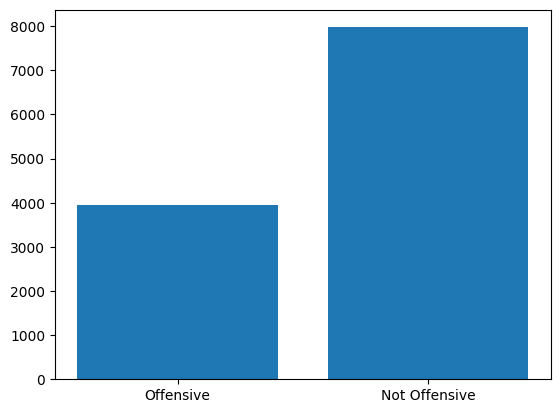

In [7]:
# QUESTION: plot a bar chart of the label distribution
#--- ADD YOUR SOLUTION HERE (5 points) ---

NO_count=dataset['train']['label'].count(0)
O_count=dataset['train']['label'].count(1)
print(O_count,NO_count)
plt.bar(['Offensive','Not Offensive'],[O_count,NO_count])
plt.show()
#------------------------------
# Hint: it is not evenly distributed

In [8]:
# QUESTION: separate data set into training, validation and test according to given dataset split
# You should end up with the following variables
# train_text = array containing strings in training set
# train_labels = array containing numeric labels in training set
# validation_text = array containing strings in training set
# validation_labels = array containing numeric labels in training set
# test_text = array containing strings in training set
# test_labels = array containing numeric labels in training set

#--- ADD YOUR SOLUTION HERE (10 points) ---

train_text = dataset['train']['text']
train_labels = dataset['train']['label']

validation_text = dataset['validation']['text']
validation_labels = dataset['validation']['label']

test_text = dataset['test']['text']
test_labels = dataset['test']['label']

#------------------------------


In [9]:
# check the size of the data splits
print("#train: ", len(train_text))
print("#validation: ", len(validation_text))
print("#test: ", len(test_text))

# Hint: you should see
#train:  11916
#validation:  1324
#test:  860

#train:  11916
#validation:  1324
#test:  860


In [10]:
#
# QUESTION: create a scikit-learn pipeline object that creates unigram features, applies tf-idf weighting and trains a SGDClassifier
# tf-idf stands for “Term Frequency times Inverse Document Frequency”.
# tf-idf is a feature weighting methods commonly used in NLP and IR
# use default parameters for unigram feature extraction, tf-idf and the SGDClassifier
# add additional import statements in this cell as needed

#--- ADD YOUR SOLUTION HERE (10 points) ---
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
pipe = Pipeline([('tfidf_vectorizer',TfidfVectorizer()),("sgd_classifier",SGDClassifier())])
#------------------------------
# Hint: use the scikit-learn library

# Train the model


In [11]:
#
# QUESTION: apply your pipeline of feature extraction and model training to the training set
# Measure the wall-clock training time needed
# Store the training time in a variable 'train_time_sgd
#--- ADD YOUR SOLUTION HERE (5 points) ---
start_time = time.time()
pipe.fit(train_text, train_labels)
end_time = time.time()
train_time_sgd = end_time - start_time
#------------------------------


In [12]:
print(f"Training time: {train_time_sgd}s")

# Hint: training should take < 1 sec

Training time: 0.41313982009887695s


# Test the model


In [13]:
#
# QUESTION: compute the majority class baseline score on the validation set and test set
# the majority class baseline is the score you get if you always predict the most frequent label
#
# Compute the precision, recall and F1 score for the majority baseline for validation and test set for each class
#
#--- ADD YOUR SOLUTION HERE (5 points) ---

if NO_count>O_count:
  mcb=0
else:
  print(O_count)
  mcb=1

val_predictions = np.array([mcb]*len(validation_text))
test_predictions = np.array([mcb]*len(test_text))

val_precision = metrics.precision_score(validation_labels, val_predictions,pos_label=mcb)
val_recall = metrics.recall_score(validation_labels, val_predictions,pos_label=mcb)
val_f1 = metrics.f1_score(validation_labels, val_predictions,pos_label=mcb)

test_precision = metrics.precision_score(test_labels, test_predictions,pos_label=mcb)
test_recall = metrics.recall_score(test_labels, test_predictions,pos_label=mcb)
test_f1 = metrics.f1_score(test_labels, test_predictions,pos_label=mcb)

print("Validation Precision:", val_precision)
print("Validation Recall:", val_recall)
print("Validation F1 Score:", val_f1)
print()
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test F1 Score:", test_f1)

#------------------------------


Validation Precision: 0.6533232628398792
Validation Recall: 1.0
Validation F1 Score: 0.7903152124257652

Test Precision: 0.7209302325581395
Test Recall: 1.0
Test F1 Score: 0.8378378378378378


In [15]:
#
#
# QUESTION: now use your pipeline to make predictions on validation and test set
# compute and print accuracy, precision, recall, F1 score
#
# From now on, we are only concerned with the F1 score for the "positive" class which are the offensive tweets
# Store the test F1 score for the "positive" class in a variable 'f1_validation_sgd' and 'f1_test_sgd' for validation and test set, respectively
#--- ADD YOUR SOLUTION HERE (10 points) ---
val_pipe=pipe.predict(validation_text)
test_pipe=pipe.predict(test_text)

val_pipe_accuracy=metrics.accuracy_score(validation_labels,val_pipe)
test_pipe_accuracy=metrics.accuracy_score(test_labels,test_pipe)

val_pipe_recall = metrics.recall_score(validation_labels, val_pipe)
test_pipe_recall = metrics.recall_score(test_labels, test_pipe)

val_pipe_precision = metrics.precision_score(validation_labels, val_pipe)
test_pipe_precision = metrics.precision_score(test_labels, test_pipe)

val_pipe_f1 = metrics.f1_score(validation_labels, val_pipe)
test_pipe_f1 = metrics.f1_score(test_labels, test_pipe)

print("Validation Accuracy:", val_pipe_accuracy)
print("Validation Precision:", val_pipe_precision)
print("Validation Recall:", val_pipe_recall)
print("Validation F1 Score:", val_pipe_f1)
print()
print("Test Accuracy:", test_pipe_accuracy)
print("Test Precision:", test_pipe_precision)
print("Test Recall:", test_pipe_recall)
print("Test F1 Score:", test_pipe_f1)

#------------------------------
# Hint: F1 scores should be >50%

Validation Accuracy: 0.7613293051359517
Validation Precision: 0.8235294117647058
Validation Recall: 0.39651416122004357
Validation F1 Score: 0.5352941176470588

Test Accuracy: 0.8058139534883721
Test Precision: 0.8288288288288288
Test Recall: 0.38333333333333336
Test F1 Score: 0.5242165242165242


# BERT model

Now let us try a more powerful model: the DistilBERT uncased model

https://huggingface.co/distilbert-base-uncased

In [16]:
# load DistilBERT tokenizer and tokenize data set
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
train_dataset = tokenized_datasets["train"]
eval_dataset = tokenized_datasets["validation"]
test_dataset = tokenized_datasets["test"]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/11916 [00:00<?, ? examples/s]

Map:   0%|          | 0/860 [00:00<?, ? examples/s]

Map:   0%|          | 0/1324 [00:00<?, ? examples/s]

In [17]:
# load DistilBERT model for classification

#--- ADD YOUR SOLUTION HERE (5 points) ---
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(set(dataset['train']['label'])))
#------------------------------
# Hint: make sure your model corresponds to your tokenizer

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
# add custom metrics that computes precision, recall, f1, accuracy

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    # Calculate accuracy
    accuracy = accuracy_score(labels, preds)

   # Calculate precision, recall, and F1-score
    precision = precision_score(labels, preds, average='binary')
    recall = recall_score(labels, preds, average='binary')
    f1 = f1_score(labels, preds, average='binary')

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [19]:

#
# QUESTION: configure the training parameters using the Huggingface TrainingArguments class
# - set the output directory to "finetuning-tweeteval"
# - do not report training metrics to an external experiment tracking service
# - print acc/p/r/f1 scores on the validation set every 200 steps
# - learning rate to 2e-5,
# - set weight decay to 0.01
# - set epochs to 1


#--- ADD YOUR SOLUTION HERE (5 points) ---

training_args = TrainingArguments(
    output_dir="./finetuning-tweeteval",
    report_to="none",
    evaluation_strategy="steps",
    learning_rate=2e-5,
    weight_decay=0.01,
    num_train_epochs=1,
    logging_steps=200
    )

#------------------------------



In [20]:
# initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


In [21]:
# train the model
train_output = trainer.train()

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
200,0.567500,0.476258,0.771148,0.647727,0.745098,0.693009
400,0.480000,0.468531,0.787764,0.750000,0.581699,0.655215
600,0.456000,0.462312,0.805136,0.736471,0.681917,0.708145
800,0.478600,0.476567,0.795317,0.747368,0.618736,0.676996
1000,0.471500,0.439440,0.790785,0.713615,0.662309,0.687006
1200,0.444600,0.447655,0.801360,0.791667,0.579521,0.669182
1400,0.413000,0.442388,0.802115,0.744417,0.653595,0.696056


In [22]:
# Evaluate on training set
trainer.evaluate(train_dataset)

{'eval_loss': 0.36436763405799866,
 'eval_accuracy': 0.8478516280631084,
 'eval_precision': 0.8021010789324248,
 'eval_recall': 0.7168231413346866,
 'eval_f1': 0.7570682031354683,
 'eval_runtime': 191.1876,
 'eval_samples_per_second': 62.326,
 'eval_steps_per_second': 7.793,
 'epoch': 1.0}

In [23]:
# Evaluate on validation set
trainer.evaluate(eval_dataset)

{'eval_loss': 0.439229816198349,
 'eval_accuracy': 0.8036253776435045,
 'eval_precision': 0.7444717444717445,
 'eval_recall': 0.6601307189542484,
 'eval_f1': 0.6997690531177829,
 'eval_runtime': 20.6624,
 'eval_samples_per_second': 64.078,
 'eval_steps_per_second': 8.034,
 'epoch': 1.0}

In [24]:
# Evaluate on test set
test_output = trainer.evaluate(test_dataset)
print(test_output)

{'eval_loss': 0.37436962127685547, 'eval_accuracy': 0.8476744186046512, 'eval_precision': 0.7684729064039408, 'eval_recall': 0.65, 'eval_f1': 0.7042889390519187, 'eval_runtime': 13.2417, 'eval_samples_per_second': 64.947, 'eval_steps_per_second': 8.156, 'epoch': 1.0}


### QUESTION:
Do you see any signs of overfitting or underfitting based on the evaluation scores
Explain why or why not

**--- ADD YOUR SOLUTION HERE (5 points) ---**

------------------------------
Training, Validation and Test metric scores are very similar to each other indicating no underfitting or overfitting. If it was overfitting training accuracy would be very high but validation and testing would be low. If it was underfitting, all metrics would be very low. Neither of them are the case.


In [25]:
#
# QUESTION: What is the ratio f1 score to training time for the SGDClassifier and the DistilBERT model
# compute the two ratios and print them

#--- ADD YOUR SOLUTION HERE ---

ratio_sgd = test_pipe_f1/train_time_sgd
ratio_bert = test_output['eval_f1']/train_output.metrics['train_runtime']
print("Ratio SGD: ", ratio_sgd)
print("Ratio DistilBERT: ", ratio_bert)
#------------------------------


Ratio SGD:  1.268859835614643
Ratio DistilBERT:  0.0009965590919466753


### QUESTION:
Given the results what model would you recommend to use? Write a paragraph (max 200 words) to explain your choice

**--- ADD YOUR SOLUTION HERE (10 points)---**

------------------------------
I would prefer to use DistilBERT although it has a higher training time. The boost in accuracy and F1 score makes it a better choice. However its slower compared to the SGD classifier so if speed is of the essence, SGD is still remains a valid option.

# End

This concludes assignment 1.


Please submit this notebook with your answers and the generated output cells as a **Jupyter notebook file** via github.


1. Create a private github repository **sutd_5055mlop** under your github user.
2. Add your instructors as collaborator: ddahlmeier and lucainiaoge
3. Save your submission as assignment_01_STUDENT_NAME.ipynb where STUDENT_NAME is your name in your SUTD email address.
4. Push the submission file to your repo
5. Submit the link to the repo via eDimensions

Example:<br/>
Email: michael_tan@mymail.sutd.edu.sg<br/>
STUDENT_NAME: michael_tan<br/>
Submission file name: assignment_01_michael_tan.ipynb



**Assignment due 01 March 2025 11:59pm**


